## TD3: Twin Delayed Deep Deterministic policy gradient

双延迟深度确定性策略梯度

时序差分和策略迭代的结合体

使用delay模型,类似DQN的双模型的思路,缓解自举

action模型根据state计算动作,**两个**value模型评估action的价值, 取小值，进一步缓解自举

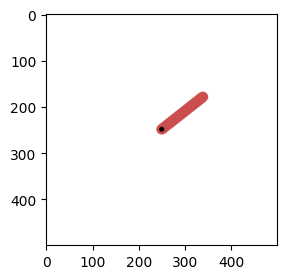

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step([action * 2])
    over = terminated or truncated

    # 偏移reward便于训练
    reward = (reward + 8) / 8
    
    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch
	
# 演员模型：计算动作概率
class Model(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.s = torch.nn.Sequential(
      torch.nn.Linear(3, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 1),
      torch.nn.Tanh(),
    )
    
  def forward(self, state):
    return  self.s(state)

model_action = Model()
model_action_delay = Model()
model_action_delay.load_state_dict(model_action.state_dict())

model_action(torch.randn(2, 3))

tensor([[0.1187],
        [0.1347]], grad_fn=<TanhBackward0>)

In [3]:
model_value1 = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)

model_value1_delay = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)


model_value1_delay.load_state_dict(model_value1.state_dict())

model_value2 = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)

model_value2_delay = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)


model_value2_delay.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4)), model_value2(torch.randn(2, 4))

(tensor([[0.1375],
         [0.1209]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0401],
         [ 0.0662]], grad_fn=<AddmmBackward0>))

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    # 根据环境采样
    action = model_action(torch.FloatTensor(state).reshape(1, 3)).item()

    # 给动作添加噪声，增加探索
    action += random.normalvariate(mu=0, sigma=0.2)
    
    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward
    
    state = next_state

    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum

play()[-1]

-10.353331249425546

In [5]:
class Pool:
  
  def __init__(self):
    self.pool = []
    
  def __len__(self):
    return len(self.pool)
  
  def __getitem__(self, i):
    return self.pool[i]
  
  # 更新动作
  def update(self):
    # 每次更新至少N条数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
      self.pool.extend(play()[0])
      
    # 保留最新N条数据
    self.pool = self.pool[-2_0000:]
    
  def sample(self):
    data = random.sample(self.pool, 64)
    
    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
    action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)
    
    return state, action, reward, next_state, over
  
pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()
next_state.shape, len(pool), pool[0]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_1872\2499438979.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(torch.Size([64, 3]),
 200,
 (array([-0.3383915 , -0.9410054 ,  0.82540524], dtype=float32),
  0.3068658066304367,
  0.5325531355693616,
  array([-0.32841167, -0.94453466,  0.21171091], dtype=float32),
  False))

In [6]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=5e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=5e-3)

def soft_update(_from, _to):
  for _from, _to in zip(_from.parameters(), _to.parameters()):
    value = _to.data * 0.7 + _from.data * 0.3
    _to.data.copy_(value)
    
def requires_grad(model, value):
  for param in model.parameters():
    param.requires_grad_(value)
    
requires_grad(model_action_delay, False)
requires_grad(model_value1_delay, False)
requires_grad(model_value2_delay, False)

In [7]:
# 训练actor
def train_action(state):
  requires_grad(model_action, True)
  requires_grad(model_value1, False)
  requires_grad(model_value2, False)
  
  # 首先把动作计算出来
  action = model_action(state)
  
  # 使用value网络评估动作的价值,价值是越高越好
  input = torch.cat([state, action], dim=1)
  value1 = model_value1(input)
  value2 = model_value2(input)
  loss = -torch.min(value1, value2).mean()
  
  loss.backward()
  optimizer_action.step()
  optimizer_action.zero_grad()
  
  return loss.item()

train_action(state)

0.03143426030874252

In [9]:
# critic 模型训练
def train_value(state, action, reward, next_state, over):
  requires_grad(model_value1, True)
  requires_grad(model_value2, True)
  requires_grad(model_action, False)
  
  # 计算value
  input = torch.cat([state, action], dim=1)
  value1 = model_value1(input)
  value2 = model_value2(input)
  
  # 计算targets
  next_action = model_action_delay(next_state)
  input = torch.cat([next_state, next_action], dim=1)
  with torch.no_grad():
    target1 = model_value1_delay(input)
    target2 = model_value2_delay(input)
    
  target = torch.min(target1, target2)
  target = target * 0.99 * (1 - over) + reward
  
  # 计算td loss, 更新参数
  loss1 = torch.nn.functional.mse_loss(value1, target)
  loss2 = torch.nn.functional.mse_loss(value2, target)
  
  loss1.backward()
  optimizer_value1.step()
  optimizer_value1.zero_grad()
  
  loss2.backward()
  optimizer_value2.step()
  optimizer_value2.zero_grad()
  
  return loss1.item(), loss2.item()

train_value(state, action, reward, next_state, over)

(0.085939422249794, 0.04970201104879379)

In [10]:
#训练
def train():
  model_action.train()
  model_value1.train()
  model_value2.train()

	# 共更新N轮数据
  for epoch in range(200):
    # 更新N条数据
    pool.update()
    
    # 每次更新过数据后,学习N次
    for i in range(200):
      # 采样一批
      state, action, reward, next_state, over = pool.sample()

      # 训练
      train_action(state)
      train_value(state, action, reward, next_state, over)

    soft_update(model_action, model_action_delay)
    soft_update(model_value1, model_value1_delay)
    soft_update(model_value2, model_value2_delay)

    if epoch % 20 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, len(pool), test_result)

train()

0 400 26.381450460761886
20 4400 54.02173398141434
40 8400 178.48170174273258
60 12400 161.30276167465732
80 16400 177.96170802288867
100 20000 181.91651783690364
120 20000 184.02769105736746
140 20000 177.53535868484326
160 20000 170.1979507315417
180 20000 180.07379120401524


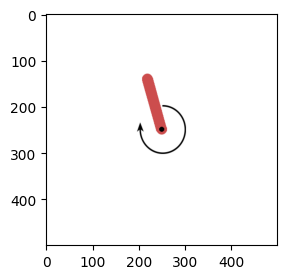

198.48259084339077

In [13]:
play(True)[-1]